In [ ]:
!pip install datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 9.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "

In [ ]:
from datasets import load_dataset

# Bailey24 Tangram veri setini indir
dataset = load_dataset("Bailey24/tangram-data")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/476 [00:00<?, ?B/s]

(…)-00000-of-00001-34dc57200ba46a60.parquet:   0%|          | 0.00/3.35M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/316 [00:00<?, ? examples/s]

In [ ]:
from datasets import load_dataset

dataset = load_dataset("Bailey24/tangram-data")
dataset["train"].select(range(5))  # İlk 5 örneği göster


Dataset({
    features: ['image', 'text'],
    num_rows: 5
})

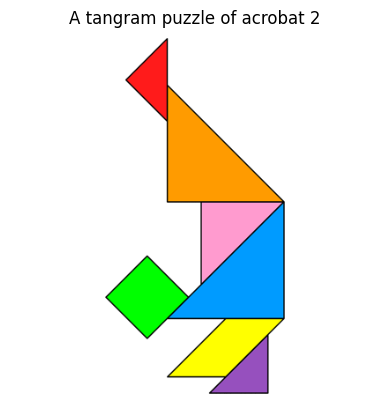

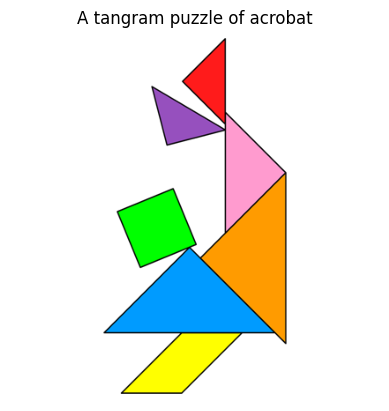

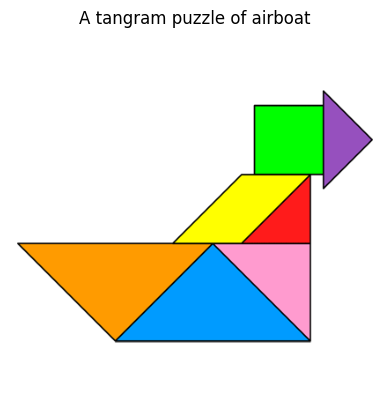

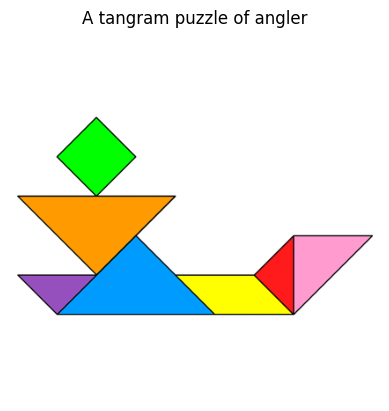

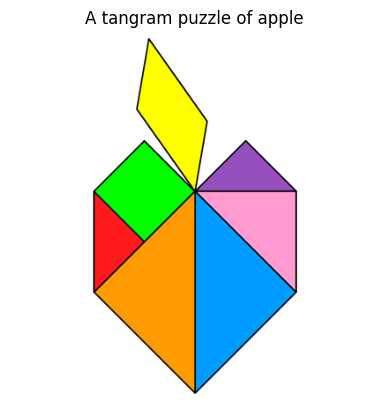

In [ ]:
import matplotlib.pyplot as plt

for i in range(5):
    example = dataset["train"][i]
    image = example["image"]
    text = example["text"]

    plt.imshow(image)
    plt.axis("off")
    plt.title(text, fontsize=12)
    plt.show()


📏 Ortalama caption uzunluğu: 5.52 kelime


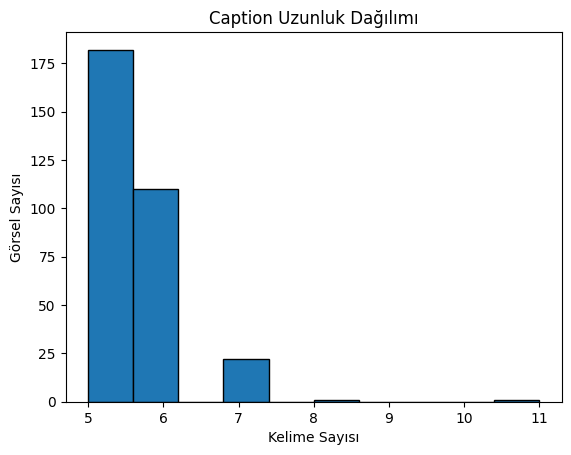

In [ ]:
from datasets import load_dataset
import matplotlib.pyplot as plt

# Dataset'i yükle
dataset = load_dataset("Bailey24/tangram-data", split="train")

# Caption uzunluklarını bul
caption_lengths = [len(example['text'].split()) for example in dataset]

# Ortalama uzunluk
avg_len = sum(caption_lengths) / len(caption_lengths)
print(f"📏 Ortalama caption uzunluğu: {avg_len:.2f} kelime")

# Histogram çiz
plt.hist(caption_lengths, bins=10, edgecolor="black")
plt.title("Caption Uzunluk Dağılımı")
plt.xlabel("Kelime Sayısı")
plt.ylabel("Görsel Sayısı")
plt.show()


In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoProcessor
from torchvision.transforms import ToTensor
from PIL import Image
import torch


In [ ]:
model_id = "nlpconnect/vit-gpt2-image-captioning"
processor = AutoProcessor.from_pretrained(model_id)
tokenizer = AutoTokenizer.from_pretrained(model_id)


preprocessor_config.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/241 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.61k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

In [ ]:
# First, make sure you have defined both:
# 1. An image processor (for handling images)
# 2. A text tokenizer (your current 'processor' variable)

# Example (you'll need to adjust this based on your actual model):
# from transformers import AutoImageProcessor, AutoTokenizer
# image_processor = AutoImageProcessor.from_pretrained("path_to_your_model")
# text_tokenizer = AutoTokenizer.from_pretrained("path_to_your_model")
# Or use your existing processor for text

class TangramDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_split, image_processor, text_tokenizer):
        self.dataset = dataset_split
        self.image_processor = image_processor
        self.text_tokenizer = text_tokenizer

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item["image"]
        caption = item.get("text", "").strip()
        if not caption:
            caption = "a tangram shape"

        # Process the image with a proper image processor
        pixel_values = self.image_processor(images=image, return_tensors="pt").pixel_values.squeeze(0)

        # Process the caption with your text tokenizer (current 'processor')
        encoding = self.text_tokenizer(
            text=caption,  # Explicitly specify text parameter
            padding="max_length",
            truncation=True,
            max_length=16,
            return_tensors="pt"
        )
        labels = encoding.input_ids.squeeze(0)

        return {
            "pixel_values": pixel_values,
            "labels": labels
        }

# Usage:
# train_dataset = TangramDataset(dataset, image_processor, processor)
# sample = train_dataset[0]
# print("📷 Görsel tensor şekli:", sample["pixel_values"].shape)
# print("📝 Caption (çözümlenmiş):", processor.decode(sample["labels"], skip_special_tokens=True))

In [ ]:
from transformers import CLIPImageProcessor
image_processor = CLIPImageProcessor.from_pretrained("openai/clip-vit-base-patch32")

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

In [ ]:
class TangramDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_split, image_processor, text_tokenizer):
        self.dataset = dataset_split
        self.image_processor = image_processor
        self.text_tokenizer = text_tokenizer

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item["image"]
        caption = item.get("text", "").strip()
        if not caption:
            caption = "a tangram shape"

        # Process the image with a proper image processor
        pixel_values = self.image_processor(images=image, return_tensors="pt").pixel_values.squeeze(0)

        # Process the caption with your text tokenizer (current 'processor')
        encoding = self.text_tokenizer(
            text=caption,
            padding="max_length",
            truncation=True,
            max_length=16,
            return_tensors="pt"
        )
        labels = encoding.input_ids.squeeze(0)

        return {
            "pixel_values": pixel_values,
            "labels": labels
        }

# Use the specific model processors
train_dataset = TangramDataset(dataset, image_processor, processor)

In [ ]:
from PIL import Image
import torchvision.transforms as transforms

# Define a basic image transformation pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class SimpleImageProcessor:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, images, return_tensors="pt"):
        if isinstance(images, Image.Image):
            image_tensor = self.transform(images).unsqueeze(0)
        else:
            # Handle batches or lists
            image_tensor = torch.stack([self.transform(img) for img in images])

        return type('obj', (object,), {'pixel_values': image_tensor})

# Create a simple image processor
image_processor = SimpleImageProcessor(transform)

# Then use it with your TangramDataset
train_dataset = TangramDataset(dataset, image_processor, processor)

In [ ]:
class SimpleImageProcessor:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, images, return_tensors="pt"):
        def convert_to_rgb(img):
            if not isinstance(img, Image.Image):
                img = Image.fromarray(img)
            if img.mode != "RGB":
                img = img.convert("RGB")
            return self.transform(img)

        if isinstance(images, Image.Image):
            image_tensor = convert_to_rgb(images).unsqueeze(0)
        else:
            image_tensor = torch.stack([convert_to_rgb(img) for img in images])

        return type('obj', (object,), {'pixel_values': image_tensor})


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  # otomatik olarak (HWC) → (CHW) + [0,1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [ ]:
image_processor = SimpleImageProcessor(transform)
train_dataset = TangramDataset(dataset, image_processor, processor)


In [ ]:
sample = train_dataset[0]
print("📷 Görsel tensor şekli:", sample["pixel_values"].shape)
print("🧠 Caption token ID’leri:", sample["labels"])
print("📝 Caption (çözümlenmiş):", tokenizer.decode(sample["labels"], skip_special_tokens=True))


📷 Görsel tensor şekli: torch.Size([3, 224, 224])
🧠 Caption token ID’leri: tensor([   32, 13875,   859, 15027,   286,   936, 40655,   362, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256])
📝 Caption (çözümlenmiş): A tangram puzzle of acrobat 2


In [ ]:
print("📝 Caption (çözümlenmiş):", tokenizer.decode(sample["labels"], skip_special_tokens=True))


📝 Caption (çözümlenmiş): A tangram puzzle of acrobat 2


In [ ]:
from transformers import VisionEncoderDecoderModel

model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
model.eval()

# Görseli işleyelim
pixel_values = image_processor(images=image, return_tensors="pt").pixel_values

# Caption üret
output_ids = model.generate(pixel_values, max_length=16, num_beams=4)
caption = tokenizer.decode(output_ids[0], skip_special_tokens=True)
print("Modelin ürettiği caption:", caption)


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/982M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/982M [00:00<?, ?B/s]

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "pooler_act": "tanh",
  "pooler_output_size": 768,
  "qkv_bias": true,
  "torch_dtype": "float32",
  "transformers_version": "4.50.3"
}

Config of the decoder: <class 'transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel'> is overwritten by shared decoder config: GPT2Config {
  "activation_function": "gelu_new",
  "add_cross_attention": true,
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "decoder_start_to

Modelin ürettiği caption: a blurry picture of a person holding a colorful object 


In [ ]:
image = dataset[0]["image"]


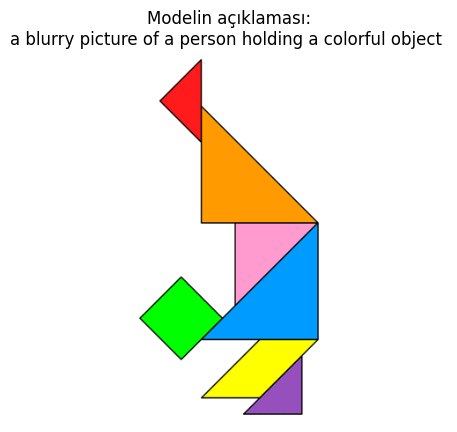

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(image)
plt.axis("off")
plt.title("Modelin açıklaması:\n" + caption)
plt.show()
